In [1]:
import torch
from peft import PeftModel, PeftConfig
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

/Users/nevidujayatilleke/Documents/FYP-Abstractive Text Summarization/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/nevidujayatilleke/Documents/FYP-Abstractive Text Summarization/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# pip install nltk rouge_score

In [3]:
# Load peft config for pre-trained checkpoint etc.
#peft_model_id = "results"
config = PeftConfig.from_pretrained("M2_LR_S2_EXT3_EXP6_model")

# load base LLM model and tokenizer
model = AutoModelForSeq2SeqLM.from_pretrained(config.base_model_name_or_path)
tokenizer = AutoTokenizer.from_pretrained(config.base_model_name_or_path)

# Load the Lora model
model = PeftModel.from_pretrained(model, "M2_LR_S2_EXT3_EXP6_model", device_map={"":0})
model.eval()

print("Peft model loaded")

'NoneType' object has no attribute 'cadam32bit_grad_fp32'
Peft model loaded


/Users/nevidujayatilleke/Documents/FYP-Abstractive Text Summarization/.venv/lib/python3.9/site-packages/bitsandbytes/cextension.py:34: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
  warn("The installed version of bitsandbytes was compiled without GPU support. "


In [5]:
from datasets import load_from_disk, DatasetDict
from random import randrange


# Load dataset from the hub and get a sample
#dataset = load_from_disk('../../Data/Textile_Patent_(70-20-10)_LexRank')
dataset = DatasetDict({
    'train': load_from_disk('../../Data/Textile_Patent_(70-20-10)_LexRank_thres_2/train'),
    'validation': load_from_disk('../../Data/Textile_Patent_(70-20-10)_LexRank_thres_2/validation'),
    'test': load_from_disk('../../Data/Textile_Patent_(70-20-10)_LexRank_thres_2/test')
})
sample = dataset['test'][randrange(len(dataset["test"])-300)]


In [6]:
input_ids = tokenizer(sample["description"], return_tensors="pt", truncation=True).input_ids.cpu()
# with torch.inference_mode():
outputs = model.generate(input_ids=input_ids, max_new_tokens=512, do_sample=True, top_p=0.9)
print(f"input sentence: {sample['description']}\n{'---'* 20}")

print(f"summary:\n{tokenizer.batch_decode(outputs.detach().cpu().numpy(), skip_special_tokens=True)[0]}")

input sentence: no . no . fig . fig . fig . fig . fig . fig . fig . in figs . in figs . figs . figs . for this purpose , according to what is shown in figs . 17 , 18 , 21 and 23 , there is provided in some of the sliders , those indicated by 314x , a housing for a slidable cleaning member . according to variations of this embodiment , the severing and sealing means may be formed , instead of by electric resistance tool , by a nozzle forming a flame beam , by ultra-sound , microwave means , or the like , which act deeply in the fabric mass . when the device is open , as shown in figs . stockings , or panty-hose elements as in fig . the fusing of the fabric is double , that is above and under the tool , thus obtaining two closures for each article at both ends thereof . when the fabric is to be constricted for severing and sealing one or both ends obtained by severing it , as the zone which is to be closed reaches the level of the slits 322 of the sliders 312 , 314 and 312 , 314x , the m

In [7]:
outputs

tensor([[    2,     0,   250,  5448,     8, 26529,    13, 12748,   253, 11610,
            11, 17465,  8244, 11269, 16430,  7201,   396,   143, 21875,    11,
             5, 37977,  7089,     6,   396,   143, 13000, 13659, 10199, 18110,
             6,    50, 20393,     6,     8,   775,    11,    10,   670,   648,
          3487,   542,  2362,  3894,  2463,   868,  6803,  2731,  9809,     5,
         32566,    29,     9,     5, 10199,    88,    10,  1367,   253,     4,
             2]])

In [8]:
import evaluate
import numpy as np
from datasets import load_from_disk
from tqdm import tqdm

# Metric
metric = evaluate.load("rouge")

def evaluate_peft_model(sample,max_target_length=512):
    # generate summary
    outputs = model.generate(input_ids=sample["input_ids"].unsqueeze(0).cpu(), do_sample=True, top_p=0.9, max_new_tokens=max_target_length)
    prediction = tokenizer.decode(outputs[0].detach().cpu().numpy(), skip_special_tokens=True)
    # decode eval sample
    # Replace -100 in the labels as we can't decode them.
    labels = np.where(sample['labels'] != -100, sample['labels'], tokenizer.pad_token_id)
    labels = tokenizer.decode(labels, skip_special_tokens=True)

    # Some simple post-processing
    return prediction, labels

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [9]:
# load test dataset from distk
test_dataset = load_from_disk("./tokenized_data_S2_EXT3/test").with_format("torch")

# run predictions
# this can take ~45 minutes
predictions, references = [] , []
for sample in tqdm(test_dataset):
    p,l = evaluate_peft_model(sample)
    predictions.append(p)
    references.append(l)

# compute metric
rogue = metric.compute(predictions=predictions, references=references, use_stemmer=True)

# print results
print(f"Rogue1: {rogue['rouge1']* 100:2f}%")
print(f"rouge2: {rogue['rouge2']* 100:2f}%")
print(f"rougeL: {rogue['rougeL']* 100:2f}%")
print(f"rougeLsum: {rogue['rougeLsum']* 100:2f}%")

# Rogue1: 50.386161%
# rouge2: 24.842412%
# rougeL: 41.370130%
# rougeLsum: 41.394230%

100%|██████████| 2259/2259 [14:10:27<00:00, 22.59s/it]    


Rogue1: 43.065791%
rouge2: 19.894283%
rougeL: 30.239836%
rougeLsum: 30.384879%


In [10]:
# Extracting Rouge scores
rouge1_score = rogue['rouge1'] * 100
rouge2_score = rogue['rouge2'] * 100
rougeL_score = rogue['rougeL'] * 100
rougeLsum_score = rogue['rougeLsum'] * 100

# Plotting the Rouge scores
labels = ['Rouge-1', 'Rouge-2', 'Rouge-L', 'Rouge-Lsum']
scores = [rouge1_score, rouge2_score, rougeL_score, rougeLsum_score]

(0.0, 100.0)

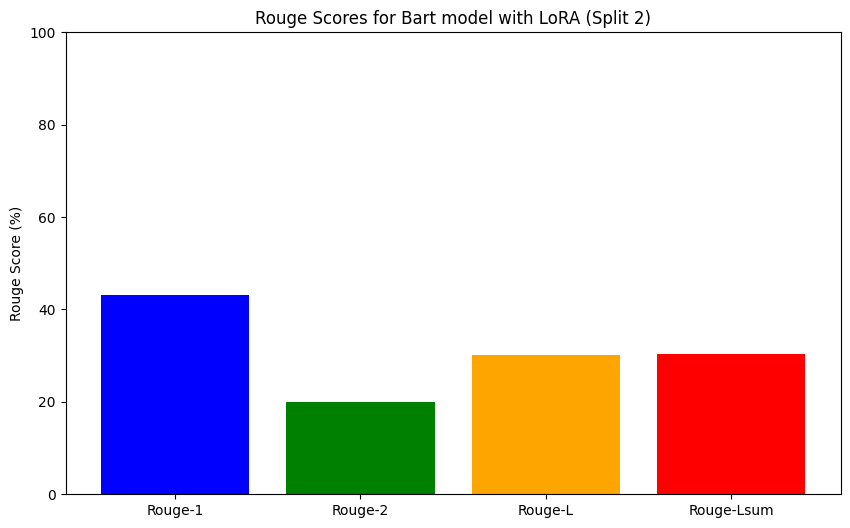

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(labels, scores, color=['blue', 'green', 'orange', 'red'])
plt.ylabel('Rouge Score (%)')
plt.title('Rouge Scores for Bart model with LoRA (Split 2)')
plt.ylim(0, 100)